In [6]:
import pandas as pd
df1 = pd.read_csv('mentalhealth.csv')
df1=df1.drop("Question_ID", axis=1)
df1.head()

,Questions,Answers
0,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [7]:
import json

with open('intents.json', 'r') as f:
    data = json.load(f)

df2 = pd.DataFrame(data['intents'])
df2=df2.drop("tag", axis=1)
df2["Questions"]=df2["patterns"]
df2["Answers"]=df2["responses"]
df2=df2.drop(["patterns", "responses"], axis=1)
df2["Questions"]=df2["Questions"].astype("str").str.replace('[','').str.replace(']','')
df2["Answers"]=df2["Answers"].astype("str").str.replace('[','').str.replace(']','')
df2.head()

,Questions,Answers
0,"'Hi', 'Hey', 'Is anyone there?', 'Hi there', '...",'Hello there. Tell me how are you feeling toda...
1,'Good morning',"""Good morning. I hope you had a good night's s..."
2,'Good afternoon','Good afternoon. How is your day going?'
3,'Good evening','Good evening. How has your day been?'
4,'Good night',"'Good night. Get some proper sleep', 'Good nig..."


In [8]:
from datasets import load_dataset

ds = load_dataset("ShenLab/MentalChat16K")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Interview_Data_6K.csv:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Synthetic_Data_10K.csv:   0%|          | 0.00/32.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16084 [00:00<?, ? examples/s]

In [9]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset("ShenLab/MentalChat16K")

# Export the 'train' split to CSV
try:
    output_file = "mentalchat16k_train.csv"
    ds["train"].to_csv(output_file, index=False)  # index=False to avoid adding row numbers
    print(f"✅ Train split saved to {output_file}")

except KeyError:
    print("❌ 'train' split not found in the dataset.")
except Exception as e:
    print(f"❌ Error while saving CSV: {e}")

Creating CSV from Arrow format:   0%|          | 0/17 [00:00<?, ?ba/s]

✅ Train split saved to mentalchat16k_train.csv


In [10]:
df3=pd.read_csv("mentalchat16k_train.csv")
df3=df3.drop("instruction", axis=1)
df3["Questions"]=df3["input"]
df3["Answers"]=df3["output"]
df3=df3.drop(["input", "output"], axis=1)
df3.head()

,Questions,Answers
0,I've been struggling with my mental health for...,I understand that you've been dealing with a s...
1,I've been feeling overwhelmed with my caregivi...,"Your situation is complex, and it's important ..."
2,I've been feeling constantly anxious and unabl...,I can see that you're dealing with a great dea...
3,"My mom has Alzheimer's, and I've been her prim...",I'm sorry to hear that your siblings' demands ...
4,"I've tried setting boundaries, but it feels li...","Your concerns are valid, and it's crucial to p..."


In [11]:
df_train= df3[:5000]
df = pd.concat([df1, df2, df_train], ignore_index=True)
df.to_csv('final_combined_subset.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  5177 non-null   object
 1   Answers    5177 non-null   object
dtypes: object(2)
memory usage: 81.0+ KB


In [12]:
import re
import random
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [13]:
for i in range(df.shape[0]):
    # Remove backslashes (escape characters)
    df['Answers'][i] = df['Answers'][i].replace('\\', '')
    df['Answers'][i] = df['Answers'][i].replace("\\'", '')

    # Remove all types of quotes
    df['Answers'][i] = df['Answers'][i].replace("'", '')
    df['Answers'][i] = df['Answers'][i].replace('"', '')

    # Remove parentheses
    df['Answers'][i] = df['Answers'][i].replace('(', '')
    df['Answers'][i] = df['Answers'][i].replace(')', '')

    # Remove commas
    df['Answers'][i] = df['Answers'][i].replace(',', '')

    # Remove hyphens and slashes
    df['Answers'][i] = df['Answers'][i].replace('-', '')
    df['Answers'][i] = df['Answers'][i].replace('/', '')

    # Replace newlines with space
    df['Answers'][i] = df['Answers'][i].replace('\n', ' ')

    # Clean up multiple spaces
    df['Answers'][i] = re.sub(r'\s+', ' ', df['Answers'][i]).strip()

# Clean Questions column
df['Questions'] = df['Questions'].astype(str).str.replace(r"[\\'\",\(\)\-/]", '', regex=True)

print(" Dataframe is now ready to be taken for next step of preprocessing")

 Dataframe is now ready to be taken for next step of preprocessing


In [14]:
pairs=[]

for i in range(df.shape[0]):
  pairs.append((df['Questions'][i],df['Answers'][i]))
print("Pairs creation completed successfully")

Pairs creation completed successfully


In [15]:
input_ques = []
target_ans = []
input_tokens = set()
target_tokens = set()

for line in pairs:

  input_doc, target_doc = line[0], line[1]

  # Appending each input sentence to input_docs
  input_ques.append(input_doc)

  # Splitting words from punctuation
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))

  # Redefine target_doc below and append it to target_docs
  target_doc = '<start> ' + target_doc + ' <end>'

  target_ans.append(target_doc)

  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split():
    if token not in target_tokens:
      target_tokens.add(token)

input_tokens = sorted(list(input_tokens))  # contains all words of input_docs
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)
print("Tokens generated successfully")

Tokens generated successfully


In [16]:
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())
print("Dictionaries of input_output features and reverse input-output features created succeesfully")

Dictionaries of input_output features and reverse input-output features created succeesfully


In [17]:
max_encoder_seq_length = 0
for input_doc in input_ques:
    length = len(re.findall(r"[\w']+|[^\s\w]", input_doc))
    if length > max_encoder_seq_length:
        max_encoder_seq_length = length

# Finding the longest sentence in bot response in decoder
max_decoder_seq_length = 0
for target_doc in target_ans:
    length = len(re.findall(r"[\w']+|[^\s\w]", target_doc))
    if length > max_decoder_seq_length:
        max_decoder_seq_length = length
print("Length of longest sentence in user input=", max_encoder_seq_length)
print("Length of longest sentence in bot response=", max_decoder_seq_length)

Length of longest sentence in user input= 341
Length of longest sentence in bot response= 1961


In [18]:
import numpy as np

# 1. Calculate the lengths of all input questions in input_ques
input_lengths = [len(re.findall(r"[\w']+|[^\s\w]", doc)) for doc in input_ques]

# 2. Calculate the lengths of all target answers in target_ans
target_lengths = [len(doc.split()) for doc in target_ans]

# 3. Determine the 95th percentile of input_lengths
max_encoder_seq_length1 = int(np.percentile(input_lengths, 95))

# 4. Determine the 95th percentile of target_lengths
max_decoder_seq_length1 = int(np.percentile(target_lengths, 95))

# 5. Print the calculated max_encoder_seq_length1 and max_decoder_seq_length1
print("95th percentile for encoder sequence length:", max_encoder_seq_length1)
print("95th percentile for decoder sequence length:", max_decoder_seq_length1)

95th percentile for encoder sequence length: 124
95th percentile for decoder sequence length: 544


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ---------------- 2. Tokenization ----------------
# Encoder tokenizer
encoder_tokenizer = Tokenizer(oov_token="<OOV>")
encoder_tokenizer.fit_on_texts(input_ques)
encoder_sequences = encoder_tokenizer.texts_to_sequences(input_ques)
num_encoder_tokens1 = len(encoder_tokenizer.word_index) + 1

# Decoder tokenizer
decoder_tokenizer = Tokenizer(oov_token="<OOV>")
decoder_tokenizer.fit_on_texts(target_ans)
decoder_sequences = decoder_tokenizer.texts_to_sequences(target_ans)
num_decoder_tokens1 = len(decoder_tokenizer.word_index) + 1

# ---------------- 3. Padding ----------------
encoder_input_data = pad_sequences(encoder_sequences, maxlen=max_encoder_seq_length1, padding='post')
decoder_input_data = pad_sequences(decoder_sequences, maxlen=max_decoder_seq_length1, padding='post')

# Decoder target data (shifted by one timestep)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

print("Tokenization Completed")

Tokenization Completed


In [20]:
# ---------------- 4. Model Parameters ----------------
dimensionality = 256
embedding_dim = 256
batch_size = 64
epochs = 100
print("Dimensions stated")

Dimensions stated


In [21]:
#Execute this

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Attention

# ---------------- 5. Encoder ----------------
encoder_inputs = Input(shape=(None,), name="encoder_input_ids")
encoder_embedding = Embedding(input_dim=num_encoder_tokens1,
                               output_dim=embedding_dim,
                               mask_zero=True,
                               name="encoder_embedding")(encoder_inputs)

# Modify encoder_lstm to return full sequences along with states for attention
encoder_lstm = LSTM(dimensionality, return_state=True, return_sequences=True, name="encoder_lstm", use_cudnn=False)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]
print("Encoder Model Structure Created with return_sequences=True")

Encoder Model Structure Created with return_sequences=True


In [22]:
#Execute this

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Layer

# Custom Attention Layer
class CustomAttention(Layer):
    def __init__(self, **kwargs):
        super(CustomAttention, self).__init__(**kwargs)

    def call(self, inputs):
        query_seq, key_seq = inputs

        # 1. Calculate attention scores (dot product)
        # scores shape: (batch_size, query_seq_len, key_seq_len)
        scores = tf.matmul(query_seq, key_seq, transpose_b=True)

        # 2. Apply mask to scores (if available)
        # Use getattr for safe access to _keras_mask
        key_mask = getattr(key_seq, '_keras_mask', None)
        if key_mask is not None:
            # Expand mask to (batch_size, 1, key_seq_len) for broadcasting with scores
            mask_for_scores = tf.expand_dims(tf.cast(key_mask, scores.dtype), 1)
            # Add a large negative number to masked out scores to effectively zero them out after softmax
            additive_mask = (1. - mask_for_scores) * -1e9
            scores += additive_mask

        # Optional: Apply query mask (prevents attention from being given to padded query outputs themselves)
        query_mask = getattr(query_seq, '_keras_mask', None)
        if query_mask is not None:
            # Expand mask to (batch_size, query_seq_len, 1)
            query_mask_for_scores = tf.expand_dims(tf.cast(query_mask, scores.dtype), 2)
            additive_query_mask = (1. - query_mask_for_scores) * -1e9
            scores += additive_query_mask

        # 3. Softmax to get attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1) # (batch_size, query_seq_len, key_seq_len)

        # 4. Apply attention weights to key_seq (values)
        # context_vector shape: (batch_size, query_seq_len, key_dim)
        context_vector = tf.matmul(attention_weights, key_seq)

        return context_vector

# ---------------- 6. Decoder with Manual Attention ----------------
decoder_inputs = Input(shape=(None,), name="decoder_input_ids")

# Retrieve the decoder embedding layer from the already defined model
decoder_embedding_layer_instance = Embedding(input_dim=num_decoder_tokens1,
                               output_dim=embedding_dim,
                               mask_zero=True,
                               name="decoder_embedding")(decoder_inputs)

# Retrieve the decoder LSTM layer from the already defined model
decoder_lstm_layer_instance = LSTM(dimensionality, return_sequences=True, return_state=True, name="decoder_lstm", use_cudnn=False)
decoder_outputs, _, _ = decoder_lstm_layer_instance(decoder_embedding_layer_instance, initial_state=encoder_states)

# Manual Attention Mechanism using the custom layer
manual_attention_layer = CustomAttention(name="manual_attention_layer")
context_vector = manual_attention_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_combined_context = Concatenate(axis=-1, name="decoder_concat_layer")([decoder_outputs, context_vector])

# Retrieve the global decoder_dense layer instance
decoder_dense_layer_instance = Dense(num_decoder_tokens1, activation='softmax', name="decoder_dense")
decoder_outputs = decoder_dense_layer_instance(decoder_combined_context)
print("Decoder Model Structure Created with Manual Attention Mechanism and updated dimensionality")

Decoder Model Structure Created with Manual Attention Mechanism and updated dimensionality


In [23]:
#Execute this

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Apply gradient clipping and a lower learning rate to the Adam optimizer
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics= ["accuracy"])
print("Training Model Compilation Done with Manual Attention Mechanism")

Training Model Compilation Done with Manual Attention Mechanism


In [24]:
#Execute this

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input_ids   │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input_ids   │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_embedding   │ (None, None, 256) │  2,071,552 │ encoder_input_id… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_input_id… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_embedding   │ (None, None, 256) │  2,471,936 │ decoder_input_id… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, None,     │    525,312 │ encoder_embeddin… │
│                     │ 256), (None,      │            │ not_equal[0][0]   │
│                     │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    525,312 │ decoder_embeddin… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256), (None,      │            │ encoder_lstm[0][… │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ manual_attention_l… │ (None, None, 256) │          0 │ decoder_lstm[0][… │
│ (CustomAttention)   │                   │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_concat_lay… │ (None, None, 512) │          0 │ decoder_lstm[0][… │
│ (Concatenate)       │                   │            │ manual_attention… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, None,      │  4,953,528 │ decoder_concat_l… │
│ (Dense)             │ 9656)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,547,640 (40.24 MB)

 Trainable params: 10,547,640 (40.24 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Execute this
from keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model_epoch_{epoch:02d}.h5', save_freq='epoch', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history= model.fit(
    [encoder_input_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # shape (samples, seq_len, 1)
    batch_size=batch_size, # Use the updated batch_size
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("Training Completed with Manual Attention Mechanism and updated sequence lengths")

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 67s 716ms/step - accuracy: 0.5461 - loss: 8.3843 - val_accuracy: 0.5717 - val_loss: 4.1706
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 465ms/step - accuracy: 0.5903 - loss: 3.4908 - val_accuracy: 0.5717 - val_loss: 2.8382
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.5897 - loss: 2.6841 - val_accuracy: 0.5717 - val_loss: 2.6228
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 470ms/step - accuracy: 0.6037 - loss: 2.5379 - val_accuracy: 0.5916 - val_loss: 2.5972
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 468ms/step - accuracy: 0.6084 - loss: 2.5096 - val_accuracy: 0.5920 - val_loss: 2.5857
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 471ms/step - accuracy: 0.6126 - loss: 2.4668 - val_accuracy: 0.5954 - val_loss: 2.5770
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 472ms/step - accuracy: 0.6104 - loss: 2.4859 - val_accuracy: 0.5976 - val_loss: 2.5665
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.6146 - loss: 2.4679 - 

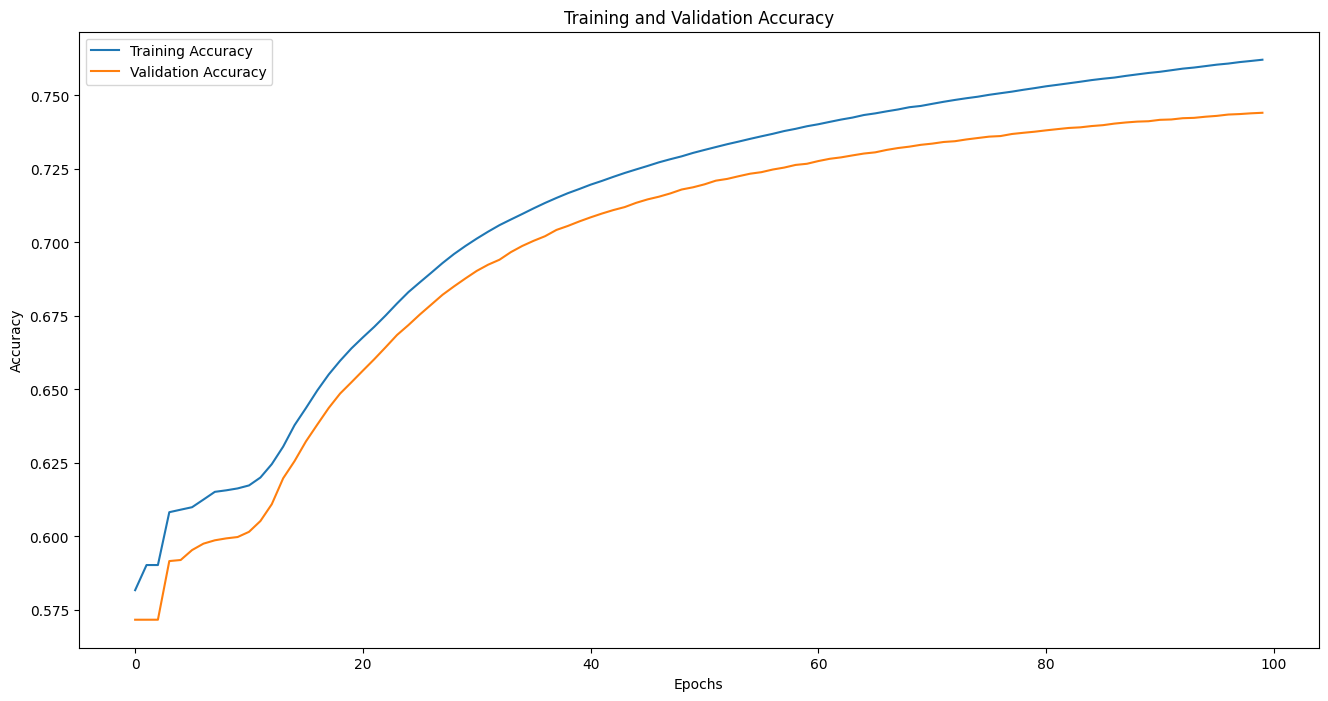

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16,8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

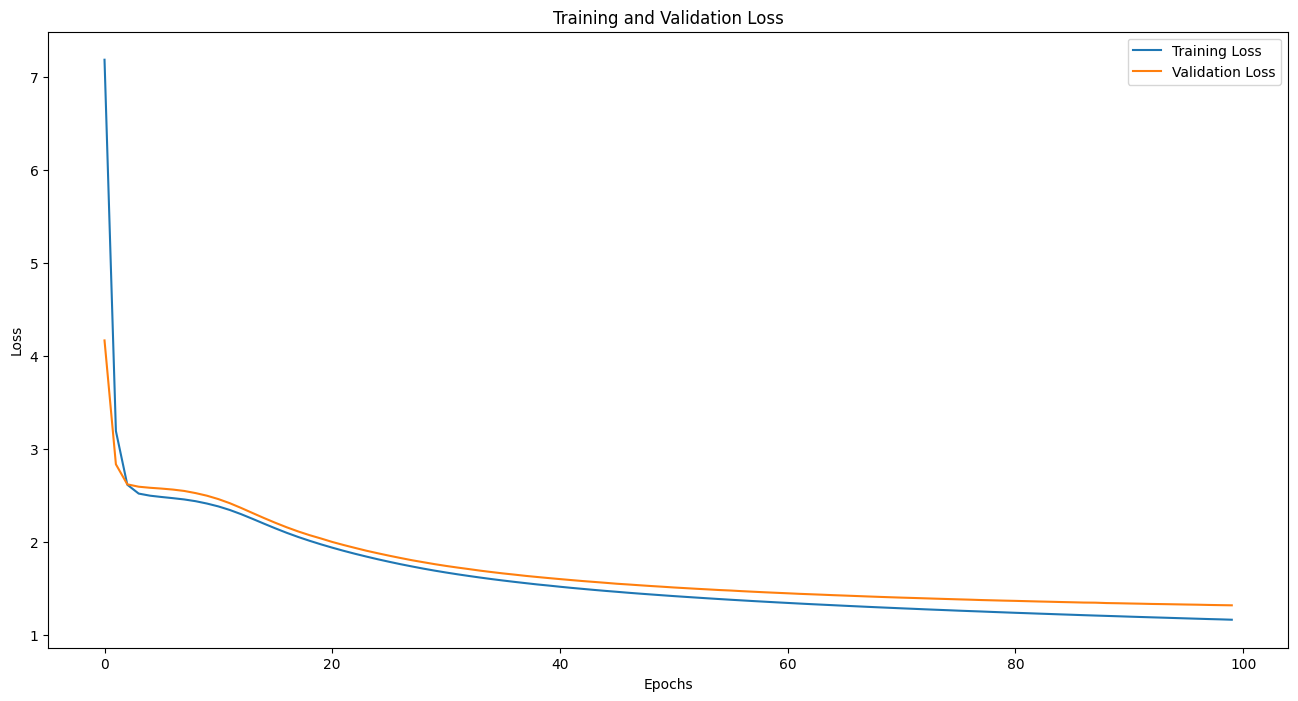

In [27]:
plt.figure(figsize=(16,8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [34]:
# Save the training model
model.save('training_model.h5')

# Save encoder model for inference
encoder_model.save('encoder_model.h5')

# Save decoder model for inference
decoder_model.save('decoder_model.h5')

# Download all three files
from google.colab import files
files.download('training_model.h5')
files.download('encoder_model.h5')
files.download('decoder_model.h5')

print("✅ All models saved and downloading!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ All models saved and downloading!


In [36]:
files.download('decoder_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import pickle

# Save tokenizers
with open('encoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(encoder_tokenizer, f)

with open('decoder_tokenizer.pkl', 'wb') as f:
    pickle.dump(decoder_tokenizer, f)

# Save other needed variables
config = {
    'max_encoder_seq_length': max_encoder_seq_length1,
    'max_decoder_seq_length': max_decoder_seq_length1,
    'num_encoder_tokens': num_encoder_tokens1,
    'num_decoder_tokens': num_decoder_tokens1
}

with open('config.pkl', 'wb') as f:
    pickle.dump(config, f)

# Download all
files.download('encoder_tokenizer.pkl')
files.download('decoder_tokenizer.pkl')
files.download('config.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define a more reasonable maximum response length for inference
INFERENCE_MAX_RESPONSE_LENGTH = 50  # You can adjust this value as needed
print(f"Inference maximum response length set to: {INFERENCE_MAX_RESPONSE_LENGTH}")

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Attention

# ---------------- 9. Inference Models ----------------
# Encoder inference model
# Modified to return encoder_outputs in addition to states
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder inference model setup
decoder_state_input_h = Input(shape=(dimensionality,), name="decoder_h_input")
decoder_state_input_c = Input(shape=(dimensionality,), name="decoder_c_input")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# We also need the encoder outputs for attention during inference
encoder_outputs_input = Input(shape=(None, dimensionality), name="encoder_outputs_input")

# Retrieve the decoder embedding layer from the trained model
decoder_embedding_layer = model.get_layer('decoder_embedding')
dec_emb2 = decoder_embedding_layer(decoder_inputs)

# Retrieve the decoder LSTM layer from the trained model
decoder_lstm_layer = model.get_layer('decoder_lstm')
decoder_outputs2, state_h2, state_c2 = decoder_lstm_layer(
    dec_emb2, initial_state=decoder_states_inputs
)

# Retrieve the attention layer from the trained model
attention_layer_for_inference = model.get_layer('manual_attention_layer')
context_vector_inference = attention_layer_for_inference([decoder_outputs2, encoder_outputs_input])

# Concatenate attention output and decoder LSTM output for inference
decoder_combined_context_inference = Concatenate(axis=-1, name="decoder_concat_inference")([decoder_outputs2, context_vector_inference])

# Retrieve the decoder Dense layer from the trained model
decoder_dense_layer = model.get_layer('decoder_dense')
decoder_outputs2 = decoder_dense_layer(decoder_combined_context_inference)
decoder_states2 = [state_h2, state_c2]

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs + [encoder_outputs_input],
    [decoder_outputs2] + decoder_states2
)
print("Inference Models Created with Attention Mechanism")

Inference Models Created with Attention Mechanism


In [39]:
#---------------- 10. Reverse Lookup Tables ----------------
reverse_target_index = {i: word for word, i in decoder_tokenizer.word_index.items()}
reverse_target_index[0] = "<PAD>"
target_token_index = decoder_tokenizer.word_index
print("Reverse Lookup Tables Created")

Reverse Lookup Tables Created


In [43]:
# Define a more reasonable maximum response length for inference
INFERENCE_MAX_RESPONSE_LENGTH = 50  # You can adjust this value as needed
print(f"Inference maximum response length set to: {INFERENCE_MAX_RESPONSE_LENGTH}")

Inference maximum response length set to: 50


In [54]:
import re
import random
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# ---------------- 11. Prediction Function ----------------
def decode_sequence(input_seq, repetition_penalty=1.5):
    # Encode input and retrieve encoder outputs and states
    encoder_output_seq, h, c = encoder_model.predict(input_seq)
    states_value = [h, c]

    # Start token
    start_token_id = target_token_index.get('<start>', 1)
    target_seq = np.array([[start_token_id]])

    decoded_sentence = ""
    stop_condition = False
    generated_tokens = [] # To keep track of generated tokens for repetition penalty

    while not stop_condition:
        # Pass encoder_output_seq to the decoder model for attention
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value + [encoder_output_seq]
        )

        # Apply repetition penalty
        # Create a copy to avoid modifying the original logits
        penalized_output_tokens = np.copy(output_tokens[0, -1, :])
        for i, token_id in enumerate(generated_tokens):
            if token_id == 0: continue # Skip padding tokens
            penalized_output_tokens[token_id] /= repetition_penalty

        sampled_token_index = np.argmax(penalized_output_tokens)
        sampled_word = reverse_target_index.get(sampled_token_index, "<OOV>")

        if sampled_word == "<end>":
            stop_condition = True
        elif sampled_word == "<PAD>": # Skip padding tokens
            pass
        elif sampled_word != "<OOV>": # Add word if not an OOV token
            decoded_sentence += " " + sampled_word
            generated_tokens.append(sampled_token_index)

        # Add a fallback to stop if the sentence becomes too long, even without <end>
        if len(generated_tokens) >= INFERENCE_MAX_RESPONSE_LENGTH and not stop_condition:
            stop_condition = True

        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    # Final cleaning: remove any remaining <PAD>, <OOV>, or <end> tokens and strip whitespace
    decoded_sentence = decoded_sentence.replace("<PAD>", "").replace("<OOV>", "").replace("<end>", "").strip()

    return decoded_sentence

In [55]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry", "not interested")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop", "leave it")

  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs!\n")

    if user_response.lower() in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)

  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")

  #Method to convert user input into a matrix (tokenized and padded sequence)
  def string_to_matrix(self, user_input):
    # Tokenize the input sentence
    tokens = encoder_tokenizer.texts_to_sequences([user_input])
    # Pad the sequence to the maximum encoder sequence length used in training
    padded_tokens = pad_sequences(tokens, maxlen=max_encoder_seq_length1, padding='post')
    return padded_tokens

  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_sequence(input_matrix)
    # Remove <start> and <end> tokens from chatbot_response (if they somehow remain)
    chatbot_response = chatbot_response.replace("<start>",'') # Use lowercase <start>
    chatbot_response = chatbot_response.replace("<end>",'')   # Use lowercase <end>
    chatbot_response = chatbot_response.replace("<OOV>",'')   # Remove <OOV> tokens
    chatbot_response = chatbot_response.replace("<PAD>",'')   # Remove <PAD> tokens
    return chatbot_response.strip() # Strip any leading/trailing spaces

  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply.lower(): # Convert reply to lowercase for consistent checking
        print("Ok, have a great day!")
        return True
    return False

chatbot = ChatBot()

In [56]:
#Execute this

# ---------------- 12. Chat Example ----------------
test_sentence = "hello how are you"
# Tokenize and pad the input sentence using the correct tokenizer and max length
test_seq = encoder_tokenizer.texts_to_sequences([test_sentence])
test_seq = pad_sequences(test_seq, maxlen=max_encoder_seq_length1, padding='post')

print("User:", test_sentence)
print("Bot:", chatbot.generate_response(test_sentence))

User: hello how are you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

# Task
The chatbot has been improved by increasing the repetition penalty from 1.2 to 1.5 in the `decode_sequence` function and adjusting the stopping condition to explicitly limit the number of generated tokens by `INFERENCE_MAX_RESPONSE_LENGTH`. Test the chatbot to evaluate if the responses are now more concise and coherent, with reduced repetition, and then summarize the improvements and confirm the resolution of previous issues.

## Increase Repetition Penalty

### Subtask:
Modify the `decode_sequence` function in cell `JxcsVFfbKpr6` to increase the `repetition_penalty` from 1.2 to 1.5. This should discourage the model from generating the same words or phrases repeatedly.
